In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import os
import json
import time
import random
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.display import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 1
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Common parameters

In [0]:
batch_size = 32
# Percentage of training data
learning_rate = 0.001

## n-copy task dataset

The entire dataset comprises of the binary representation of all numbers uptil a range defined. The binary sequence from left to right (most significant to least significant) is the input. The target is just the reverse sequence.

In [3]:
from seq_seq_different import create_ncopy_task

# Start token
START = torch.tensor([1,1]).to(device)

# normal sequence
train_loader, test_loader, valid_loader = create_ncopy_task(sequence_length=15, 
                                                            n_copy=10,
                                                            batch_size=batch_size,
                                                            start_token=1,
                                                            train_test_ratio=0.9, 
                                                            train_valid_ratio=0.8,
                                                            verbose=True)

# sequence with longer output
long_output_train_loader, \
long_output_test_loader, \
long_output_val_loader = create_ncopy_task(sequence_length=15, 
                                           n_copy=20,
                                           batch_size=batch_size,
                                           start_token=1,
                                           train_test_ratio=0.9, 
                                           train_valid_ratio=0.8)

# Sequence with longer input
long_input_train_loader, \
long_input_test_loader, \
long_input_val_loader = create_ncopy_task(sequence_length=25, 
                                           n_copy=10,
                                           batch_size=batch_size,
                                           start_token=1,
                                           train_test_ratio=0.9, 
                                           train_valid_ratio=0.8)


torch.Size([16, 9000, 2]) torch.Size([151, 9000, 2])
torch.Size([16, 1000, 2]) torch.Size([151, 1000, 2])
torch.Size([16, 9000, 2]) torch.Size([301, 9000, 2])
torch.Size([16, 1000, 2]) torch.Size([301, 1000, 2])
torch.Size([26, 9000, 2]) torch.Size([251, 9000, 2])
torch.Size([26, 1000, 2]) torch.Size([251, 1000, 2])


# LSTM

In [0]:
# Input dim
input_dim = 2
# Number of hidden nodes
hidden_dim = 32
# Number of output nodes
output_dim = 2
# Number of LSTMs cells to be stacked
layers = 1
# Boolean value for bidirectioanl or not
bidirectional = True
# Boolean value to use LayerNorm or not
layernorm = True

## Our implementation

In [16]:
from seq_seq_different import LSTMSeq2SeqDifferent

our = LSTMSeq2SeqDifferent(input_dim, hidden_dim, output_dim, bidirectional=bidirectional, 
                           layers=layers, layernorm=layernorm).to(device)

print("Our implementation\n{}".format("=" * len("Our implementation")))
print("# of parameters: {}".format(our.count_parameters()))
for name, param in our.named_parameters():
    print("{:<40}: {}".format(name, param.shape))

Our implementation
# of parameters: 27522
encoder.model.0.weights                 : torch.Size([34, 128])
encoder.model.0.bias                    : torch.Size([128])
encoder.model.0.ln_gates.weight         : torch.Size([128])
encoder.model.0.ln_gates.bias           : torch.Size([128])
encoder.model.0.ln_candidate.weight     : torch.Size([32])
encoder.model.0.ln_candidate.bias       : torch.Size([32])
encoder.model_rev.0.weights             : torch.Size([34, 128])
encoder.model_rev.0.bias                : torch.Size([128])
encoder.model_rev.0.ln_gates.weight     : torch.Size([128])
encoder.model_rev.0.ln_gates.bias       : torch.Size([128])
encoder.model_rev.0.ln_candidate.weight : torch.Size([32])
encoder.model_rev.0.ln_candidate.bias   : torch.Size([32])
decoder.model.0.weights                 : torch.Size([66, 256])
decoder.model.0.bias                    : torch.Size([256])
decoder.model.0.ln_gates.weight         : torch.Size([256])
decoder.model.0.ln_gates.bias           : torch.Si

Beginning training model with 27522 parameters
Files will be saved in: results/Seq2SeqDifferent/lstm/


Epoch #1: Average loss is 0.6820305744806926
.........................................................
Epoch #1: Validation F1 is 0.6019741681132131
Time taken for epoch: 156.4402961730957s


Epoch #2: Average loss is 0.6431047995885213
Time taken for epoch: 141.4685411453247s


Epoch #3: Average loss is 0.6330679175588819
Time taken for epoch: 141.4116189479828s


Epoch #4: Average loss is 0.6282683560583326
Time taken for epoch: 141.72638034820557s


Epoch #5: Average loss is 0.6241913617981805
.........................................................
Epoch #5: Validation F1 is 0.683416946719756
Time taken for epoch: 152.50709581375122s


Epoch #6: Average loss is 0.6169506200154622
Time taken for epoch: 141.62164878845215s


Epoch #7: Average loss is 0.6044301748275757
Time taken for epoch: 140.11064672470093s


Epoch #8: Average loss is 0.5852687101893955
Time taken for epoch: 13

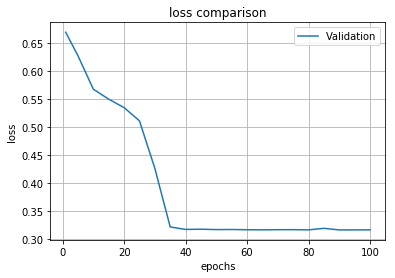

In [17]:
from seq_seq_different import Seq2SeqDifferent

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(our.parameters(), lr=learning_rate)
out_dir = 'results/Seq2SeqDifferent/lstm/'

task_our = Seq2SeqDifferent(model=our, optimizer=optimizer, loss_fn=loss_fn, device=device, teacher_forcing=0.1)

our, our_stats = task_our.train(100, train_loader, valid_loader, freq=5,
                                out_dir=out_dir, train_eval=False)

In [0]:
# from seq_seq_different import Seq2SeqDifferent

# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(our.parameters(), lr=learning_rate)
# out_dir = '/content/'

# task_our = Seq2SeqDifferent(model=our, optimizer=optimizer, loss_fn=loss_fn, device=device)


# task_our.model.load("model_epoch_100.pkl")

### Evaluate

In [18]:
our_f1 = task_our.evaluate(test_loader, True)
print(our_f1)

................................
Confusion Matrix: 
 [[75885   455]
 [    0 74660]]

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     76340
           1       0.99      1.00      1.00     74660

    accuracy                           1.00    151000
   macro avg       1.00      1.00      1.00    151000
weighted avg       1.00      1.00      1.00    151000

(0.9969621098314138, 0.3161322083324194)


In [19]:
for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)
    break
print(x.shape, y.shape)
h = torch.zeros(2 * layers, x.shape[1], our.hidden_dim).to(device)
c = torch.zeros(2 * layers, x.shape[1], our.hidden_dim).to(device)
o = our(x, y, h, c, 0)

torch.Size([16, 32, 2]) torch.Size([151, 32, 2])


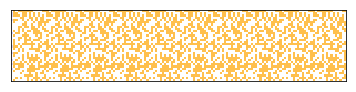

In [21]:
z1 = torch.transpose(torch.argmax(y, 2), 1, 0).detach().cpu().long().numpy()
z2 = torch.transpose(o[:,:,1], 1, 0).detach().cpu().numpy()
z2 = np.round(z2).astype(int)
# print(z1[0,:10])
# print(z2[0,:10])
# print(np.bitwise_xor(z1[0, :10], z2[0, :10]))

from matplotlib.colors import ListedColormap
# plt.matshow(np.bitwise_xor(z1, z2), cmap=cmap)
cmap1 = ListedColormap(['w', 'blue'])
img1 = plt.imshow(np.bitwise_xor(z1, z2), cmap=cmap1, alpha=0.5)
cmap2 = ListedColormap(['w', 'orange'])
img2 = plt.imshow(z1, cmap=cmap2, alpha=0.7)
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(out_dir, 'test.png'), transparent = True, 
            bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.show()

### Test with longer output

In [22]:
our_f1 = task_our.evaluate(long_output_test_loader, True)
print(our_f1)

for x, y in long_output_test_loader:
    x = x.to(device)
    y = y.to(device)
    break

h = torch.zeros(2 * layers, x.shape[1], our.hidden_dim).to(device)
c = torch.zeros(2 * layers, x.shape[1], our.hidden_dim).to(device)
o = our(x, y, h, c, 0)

................................
Confusion Matrix: 
 [[149925    455]
 [     0 150620]]

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    150380
           1       1.00      1.00      1.00    150620

    accuracy                           1.00    301000
   macro avg       1.00      1.00      1.00    301000
weighted avg       1.00      1.00      1.00    301000

(0.9984918543562207, 0.3147188238799572)


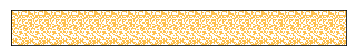

In [23]:
z1 = torch.transpose(torch.argmax(y,2), 1, 0).detach().cpu().long().numpy()
z1[:,0] = 1
z2 = torch.transpose(o[:,:,1], 1, 0).detach().cpu().numpy()
z2 = np.round(z2).astype(int)
# print(z1[0,:10])
# print(z2[0,:10])
# print(np.bitwise_xor(z1[0, :10], z2[0, :10]))

from matplotlib.colors import ListedColormap
# plt.matshow(np.bitwise_xor(z1, z2), cmap=cmap)
cmap1 = ListedColormap(['w', 'blue'])
img1 = plt.imshow(np.bitwise_xor(z1, z2), cmap=cmap1, alpha=0.7)
cmap2 = ListedColormap(['w', 'orange'])
img2 = plt.imshow(z1, cmap=cmap2, alpha=0.7)
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(out_dir, 'longer_output.png'), transparent = True, 
            bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.show()

### Test with longer input

In [25]:
our_f1 = task_our.evaluate(long_input_test_loader, True)
print(our_f1)

for x, y in long_input_test_loader:
    x = x.to(device)
    y = y.to(device)
    break

h = torch.zeros(2 * layers, x.shape[1], our.hidden_dim).to(device)
c = torch.zeros(2 * layers, x.shape[1], our.hidden_dim).to(device)
o = our(x, y, h, c, 0)

................................
Confusion Matrix: 
 [[72316 55094]
 [47686 75904]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.60      0.57      0.58    127410
           1       0.58      0.61      0.60    123590

    accuracy                           0.59    251000
   macro avg       0.59      0.59      0.59    251000
weighted avg       0.59      0.59      0.59    251000

(0.5962889059971406, 0.7223953176289797)


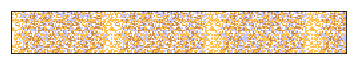

In [26]:
z1 = torch.transpose(torch.argmax(y,2), 1, 0).detach().cpu().long().numpy()
z1[:,0] = 1
z2 = torch.transpose(o[:,:,1], 1, 0).detach().cpu().numpy()
z2 = np.round(z2).astype(int)
# print(z1[0,:10])
# print(z2[0,:10])
# print(np.bitwise_xor(z1[0, :10], z2[0, :10]))

from matplotlib.colors import ListedColormap
# plt.matshow(np.bitwise_xor(z1, z2), cmap=cmap)
cmap1 = ListedColormap(['w', 'blue'])
img1 = plt.imshow(np.bitwise_xor(z1, z2), cmap=cmap1, alpha=0.7)
cmap2 = ListedColormap(['w', 'orange'])
img2 = plt.imshow(z1, cmap=cmap2, alpha=0.7)
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(out_dir, 'longer_input.png'), transparent = True, 
            bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.show()

## PyTorch implementation

In [0]:
# class PyTorchBaseline(nn.Module):
#     """ LSTM Class for Sequence Labelling (many-to-many-different)

#     The class creates the LSTM architecture as specified by the parameters.
#     A fully connected layer is added to reduce the last hidden state to output_dim.

#     Parameters
#     ==========
#     vocab_len: int from imdb dataset
#     embed_dim: dimensions of the embeddings
#     hidden_dim: number of hidden nodes required
#     output_dim: numer of output nodes required (1 for sentiment analysis)
#     pretrained_vec: weights from imdb object
#     layers: number of LSTM cells to be stacked for depth
#     bidirectional: boolean
#     layernorm: boolean

#     """
#     def __init__(self, input_dim, hidden_dim, output_dim, layers=1,
#                  bidirectional=False, layernorm=False):
#         super().__init__()

#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.hidden_dim = hidden_dim
#         self.layers = layers
#         self.bidirectional = bidirectional
#         self.layernorm = layernorm

#         self.encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=layers,
#                          bidirectional=bidirectional) #, layernorm=layernorm)
#         if self.bidirectional:
#             self.decoder = nn.LSTM(input_size=output_dim, hidden_size=2 * hidden_dim, num_layers=layers,
#                                 bidirectional=False) #, layernorm=layernorm)
#             self.fc = nn.Linear(2 * hidden_dim, output_dim)
#         else:
#             self.decoder = nn.LSTM(input_size=output_dim, hidden_size=hidden_dim, num_layers=layers,
#                                 bidirectional=False) #, layernorm=layernorm)
#             self.fc = nn.Linear(hidden_dim, output_dim)
#         self.softmax = nn.Softmax(dim=2)

#     def forward(self, x, target, hidden_state, cell_state, teacher_forcing=0.5):
#         device = 'cpu'
#         if x.is_cuda:
#             device = 'cuda'
#         # encoding
#         _, (hidden_state, cell_state) = self.encoder(x, (hidden_state, cell_state))
#         batch_size = x.shape[1]
#         timesteps = target.shape[0]
#         x = torch.zeros(1, batch_size, self.output_dim).to(device)
#         output = torch.tensor([]).to(device)
#         if self.bidirectional:
#             # concatenating hidden states from two directions
#             hidden_state = torch.cat((hidden_state[:self.layers,:,:], 
#                                       hidden_state[self.layers:,:,:]), dim=2)
#             cell_state = torch.cat((cell_state[:self.layers,:,:], 
#                                     cell_state[self.layers:,:,:]), dim=2)
#         # decoding
#         for t in range(timesteps):           
#             x, (hidden_state, cell_state) = self.decoder(x, (hidden_state, cell_state))
#             x = self.softmax(self.fc(x))
#             output = torch.cat((output, x), dim=0)
#             choice = random.random() 
#             if choice < teacher_forcing:
#                 x = target[t].float().to(device)
#                 x = x.unsqueeze(0)
#             else:
#                 # converting x to a one-hot encoding
#                 x = torch.zeros(x.shape).to(device).scatter_(2, torch.argmax(x, -1, keepdim=True), 1)
#         return output

#     def save(self, file_path='./model.pkl'):
#         torch.save(self.state_dict(), file_path)

#     def load(self, file_path):
#         self.load_state_dict(torch.load(file_path))

#     def count_parameters(self):
#         tot_sum = sum(p.numel() for p in self.encoder.parameters() if p.requires_grad)
#         tot_sum += sum(p.numel() for p in self.decoder.parameters() if p.requires_grad)
#         tot_sum += sum(p.numel() for p in self.fc.parameters() if p.requires_grad)
#         return tot_sum


In [0]:
# pytorch = PyTorchBaseline(input_dim, hidden_dim, output_dim, layers, bidirectional).to(device)
# print(pytorch.count_parameters())
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(pytorch.parameters(), lr=learning_rate)

In [0]:
# train_x = train_x.to(device)
# train_y = train_y.to(device)
# test_x = test_x.to(device)
# test_y = test_y.to(device)

# pytorch = train(pytorch, train_x, train_y, test_x, test_y, epochs=30, loss_fn=loss_fn, optimizer=optimizer, teacher_forcing=0.5)

# Transfomer

In [6]:
from seq_seq_different import TransformerSeq2SeqDifferent

pad = torch.tensor([0,0]).float()
# create model
# 26k
model = TransformerSeq2SeqDifferent(in_dim=2, out_dim=2, N=1, heads=6, model_dim=32, key_dim=4, value_dim=4, ff_dim=128,
                                          batch_first=False)
# 13k
# model = TransformerSeq2SeqDifferent(in_dim=2, out_dim=2, N=1, heads=6, model_dim=16, key_dim=4, value_dim=4, ff_dim=128,
#                                            batch_first=False)

# 5k
# model = TransformerSeq2SeqDifferent(in_dim=2, out_dim=2, N=1, heads=8, model_dim=8, key_dim=4, value_dim=4, ff_dim=64,
#                                           batch_first=False)

model = model.to(device)

print(model.count_parameters())

26810


Beginning training model with 26810 parameters
Files will be saved in: results/Seq2SeqDifferent/transformer


Epoch #1: Average loss is 0.6690706872940063
.

/content/seq_seq_different.py:271: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tgt = torch.tensor(start_token).view(1,1,-1).repeat(src.shape[0],1,1).float()


........................................................
Epoch #1: Validation F1 is 0.584318010550113
Time taken for epoch: 39.263996601104736s


Epoch #2: Average loss is 0.6381647822591994
Time taken for epoch: 4.991767406463623s


Epoch #3: Average loss is 0.534433279964659
Time taken for epoch: 5.045864820480347s


Epoch #4: Average loss is 0.3753809200392829
Time taken for epoch: 5.06983757019043s


Epoch #5: Average loss is 0.2512982248597675
.........................................................
Epoch #5: Validation F1 is 0.9757770870337478
Time taken for epoch: 38.58133888244629s


Epoch #6: Average loss is 0.153319816854265
Time taken for epoch: 4.993980884552002s


Epoch #7: Average loss is 0.10769466436571545
Time taken for epoch: 5.067109107971191s


Epoch #8: Average loss is 0.08310011661714978
Time taken for epoch: 5.021794557571411s


Epoch #9: Average loss is 0.06799107294943597
Time taken for epoch: 5.070223569869995s


Epoch #10: Average loss is 0.0563639247086313


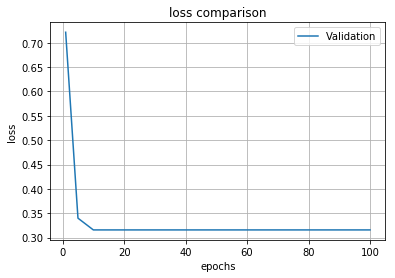

In [7]:
from seq_seq_different import Seq2SeqDifferent
from transformer import NoamOpt

out_dir = 'results/Seq2SeqDifferent/transformer'

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = NoamOpt(model.model_dim, 1, 2000,
#         torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

task_transformer = Seq2SeqDifferent(model=model, optimizer=optimizer, loss_fn=loss_fn, 
                                    start_token=START, device=device)

transformer, transformer_stats = task_transformer.train(100, train_loader, valid_loader, freq=5,
                                out_dir=out_dir, train_eval=False)

### Evaluate

In [8]:
transformer_f1 = task_transformer.evaluate(test_loader, True)
print(transformer_f1)

.

/content/seq_seq_different.py:271: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tgt = torch.tensor(start_token).view(1,1,-1).repeat(src.shape[0],1,1).float()


...............................
Confusion Matrix: 
 [[76340     0]
 [    0 74660]]

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     76340
           1       1.00      1.00      1.00     74660

    accuracy                           1.00    151000
   macro avg       1.00      1.00      1.00    151000
weighted avg       1.00      1.00      1.00    151000

(1.0, 0.31577759329229593)


In [9]:
for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)
    break
print(x.shape, y.shape)
o = model.generate(x, start_token=START, max_len=y.shape[0])

torch.Size([16, 32, 2]) torch.Size([151, 32, 2])


/content/seq_seq_different.py:271: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tgt = torch.tensor(start_token).view(1,1,-1).repeat(src.shape[0],1,1).float()


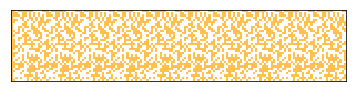

In [10]:
z1 = torch.transpose(torch.argmax(y,2), 1, 0).detach().cpu().long().numpy()
z1[:,0] = 1
z2 = torch.transpose(o[:,:,1], 1, 0).detach().cpu().numpy()
z2 = np.round(z2).astype(int)
# print(z1[0,:10])
# print(z2[0,:10])
# print(np.bitwise_xor(z1[0, :10], z2[0, :10]))

from matplotlib.colors import ListedColormap
# plt.matshow(np.bitwise_xor(z1, z2), cmap=cmap)
cmap1 = ListedColormap(['w', 'blue'])
img1 = plt.imshow(np.bitwise_xor(z1, z2), cmap=cmap1, alpha=0.5)
cmap2 = ListedColormap(['w', 'orange'])
img2 = plt.imshow(z1, cmap=cmap2, alpha=0.7)
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(out_dir, 'test.png'), transparent = True, 
            bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.show()

### Test with longer output

In [11]:
transformer_f1 = task_transformer.evaluate(long_output_test_loader, True)
print(transformer_f1)

for x, y in long_output_test_loader:
    x = x.to(device)
    y = y.to(device)
    break

o = model.generate(x, start_token=START, max_len=y.shape[0])

.

/content/seq_seq_different.py:271: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tgt = torch.tensor(start_token).view(1,1,-1).repeat(src.shape[0],1,1).float()


...............................
Confusion Matrix: 
 [[118165  32215]
 [ 32988 117632]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.79      0.78    150380
           1       0.79      0.78      0.78    150620

    accuracy                           0.78    301000
   macro avg       0.78      0.78      0.78    301000
weighted avg       0.78      0.78      0.78    301000

(0.7829944719386821, 0.5316749941557646)


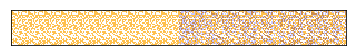

In [12]:
z1 = torch.transpose(torch.argmax(y[:],2), 1, 0).detach().cpu().long().numpy()
z1[:,0] = 1
z2 = torch.transpose(o[:,:,1], 1, 0).detach().cpu().numpy()
z2 = np.round(z2).astype(int)
# print(z1[0,:10])
# print(z2[0,:10])
# print(np.bitwise_xor(z1[0, :10], z2[0, :10]))

from matplotlib.colors import ListedColormap
# plt.matshow(np.bitwise_xor(z1, z2), cmap=cmap)
cmap1 = ListedColormap(['w', 'blue'])
img1 = plt.imshow(np.bitwise_xor(z1, z2), cmap=cmap1, alpha=0.7)
cmap2 = ListedColormap(['w', 'orange'])
img2 = plt.imshow(z1, cmap=cmap2, alpha=0.7)
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(out_dir, 'longer_output.png'), transparent = True, 
            bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.show()

### Test with longer input

In [13]:
transformer_f1 = task_transformer.evaluate(long_input_test_loader, True)
print(transformer_f1)

for x, y in long_input_test_loader:
    x = x.to(device)
    y = y.to(device)
    break

o = model.generate(x, start_token=START, max_len=y.shape[0])

.

/content/seq_seq_different.py:271: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tgt = torch.tensor(start_token).view(1,1,-1).repeat(src.shape[0],1,1).float()


...............................
Confusion Matrix: 
 [[69625 57785]
 [49943 73647]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.58      0.55      0.56    127410
           1       0.56      0.60      0.58    123590

    accuracy                           0.57    251000
   macro avg       0.57      0.57      0.57    251000
weighted avg       0.57      0.57      0.57    251000

(0.5775736995239628, 0.7443468235433102)


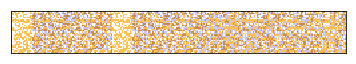

In [14]:
z1 = torch.transpose(torch.argmax(y[:],2), 1, 0).detach().cpu().long().numpy()
z1[:,0] = 1
z2 = torch.transpose(o[:,:,1], 1, 0).detach().cpu().numpy()
z2 = np.round(z2).astype(int)
# print(z1[0,:10])
# print(z2[0,:10])
# print(np.bitwise_xor(z1[0, :10], z2[0, :10]))

from matplotlib.colors import ListedColormap
# plt.matshow(np.bitwise_xor(z1, z2), cmap=cmap)
cmap1 = ListedColormap(['w', 'blue'])
img1 = plt.imshow(np.bitwise_xor(z1, z2), cmap=cmap1, alpha=0.7)
cmap2 = ListedColormap(['w', 'orange'])
img2 = plt.imshow(z1, cmap=cmap2, alpha=0.7)
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(out_dir, 'longer_input.png'), transparent = True, 
            bbox_inches = 'tight', pad_inches = 0, dpi=300)
plt.show()

In [0]:
# !zip -r results-seq_different.zip results/Seq2SeqDifferent/

# from google.colab import files
# files.download('results-seq_different.zip')